1. Installing required modules

In [21]:
# Install required modules
!pip install datasets
!pip install transformers
!pip install umap-learn

2. Import required modules

In [22]:
# Import required modules
from datasets import load_dataset, DatasetDict, Features, Value, ClassLabel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

3. Mounting google drive for accessing dataset files

In [23]:
# Mounting google drive for accessing dataset files
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


4. Creating the dataset

In [24]:
# Creating the dataset
train_file = "/content/drive/MyDrive/2022/College/COMP6321/data/train_dataset_cleaned.csv"
test_file = "/content/drive/MyDrive/2022/College/COMP6321/data/test_dataset_cleaned.csv"

data_files = {"train": train_file, "test": test_file}
class_names = ["negative", "neutral", "positive"]
emotion_features = Features({"id": Value("int64"), "label": ClassLabel(names=class_names), "text": Value("string")})
temp_dataset = load_dataset("csv", data_files=data_files, column_names=["id", "label", "text"], features=emotion_features)

temp_dataset_train_valid = temp_dataset["train"].train_test_split(test_size=0.1)
temp_dataset_train = temp_dataset_train_valid["train"]
temp_dataset_valid = temp_dataset_train_valid["test"]
dataset = DatasetDict({
    "train": temp_dataset_train,
    "valid": temp_dataset_valid,
    "test": temp_dataset["test"]})

# Removing empty text entries
dataset = dataset.filter(lambda example: example["text"] != None)
dataset = dataset.remove_columns("id")

print(dataset)

Using custom data configuration default-197a2373e4fec7aa
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-197a2373e4fec7aa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-197a2373e4fec7aa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-a9579aad954a79ef.arrow


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 25025
    })
    valid: Dataset({
        features: ['label', 'text'],
        num_rows: 2780
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1301
    })
})


5. Checking the data distribution

In [25]:
# Using pandas for checking the data distribution
dataset.set_format(type="pandas")
train_df = dataset["train"][:]

In [26]:
# Printing the first 5 examples in the train data
def label_int2str(row):
  return dataset["train"].features["label"].int2str(row)

train_df["label_name"] = train_df["label"].apply(label_int2str)
train_df.head()

,label,text,label_name
0,2,A lot of kids grew up in the west praying sala...,positive
1,1,Happy League10 🎂!!! I have RP and have been in...,neutral
2,1,Andhra Pradesh Cancels Start-Up Infra Work In ...,neutral
3,1,excuse me what the fuck,neutral
4,1,It would behoove the media to point out it is ...,neutral


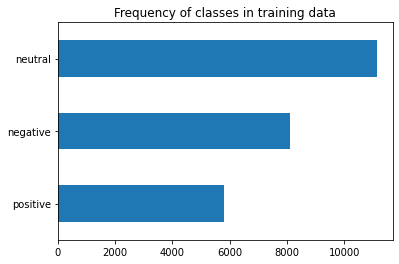

In [27]:
# Displaying the frequency of classes in the training data
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes in training data")
plt.show()

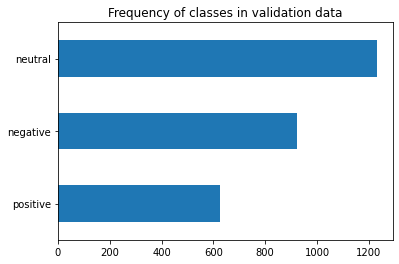

In [28]:
# Displaying the frequency of classes in the validation data
valid_df = dataset["valid"][:]
valid_df["label_name"] = valid_df["label"].apply(label_int2str)
valid_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes in validation data")
plt.show()

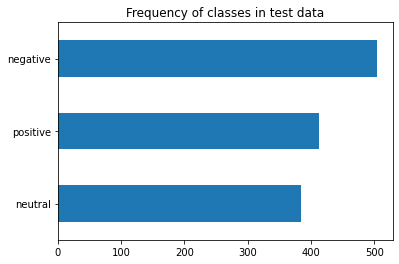

In [29]:
# Displaying the frequency of classes in the test data
test_df = dataset["test"][:]
test_df["label_name"] = test_df["label"].apply(label_int2str)
test_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes in test data")
plt.show()

In [30]:
# Resetting the dataset format
dataset.reset_format()

6. Tokenization

In [31]:
# Initializing the tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [32]:
# Defining tokenization function
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [33]:
# Applying the tokenize function across all the datasets (train/validation/test)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-197a2373e4fec7aa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-c4770fe8dd0f3153.arrow


7. Training a classifier (using feature extraction)

In [34]:
# The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states
model_checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_checkpoint).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
# Extracting the last hidden states
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [36]:
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [37]:
# Extracting hidden states across all dataset splits in one go
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Here, the hidden state corresponding to each input text is available. Next step - create a feature matrix and train a classifier using the hidden states as the input features and the labels as the targets.

8. Creating a feature matrix

In [38]:
# Creating a feature matrix
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["valid"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["valid"]["label"])

X_train.shape, X_valid.shape

((25025, 768), (2780, 768))

9. Visualizaing the hidden state data before training a classifier

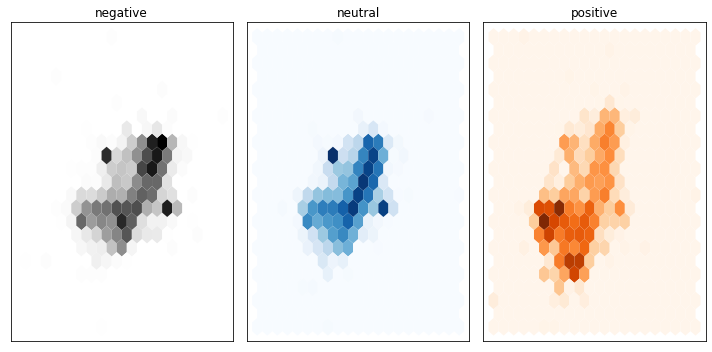

In [39]:
X_scaled = MinMaxScaler().fit_transform(X_train)          # Scaling features to [0, 1] range
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges"]
labels = dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

10. Establish baseline using a dummy classifier

In [40]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.44280575539568345

11. Print the confusion matrix for the dummy classifier

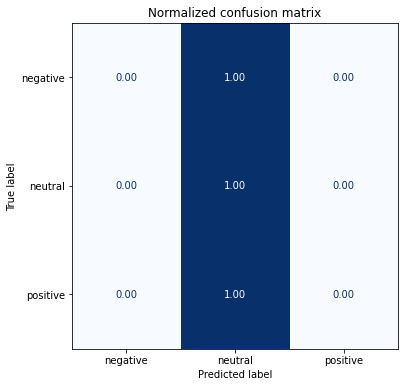

In [41]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fix, ax = plt.subplots(figsize=(6, 6))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  cm_display.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = dummy_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)